# Model Agnostic Analysis

## Introduction

In this tutorial model agnostic analysis means writing your notebook so that it can easily be used with any CF compliant data source.

### What are the CF Conventions?

From [CF Metadata conventions](https://cfconventions.org) 

> The CF metadata conventions are designed to promote the processing and sharing of files created with the NetCDF API. The conventions define metadata that provide a definitive description of what the data in each variable represents, and the spatial and temporal properties of the data. This enables users of data from different sources to decide which quantities are comparable, and facilitates building applications with powerful extraction, regridding, and display capabilities. The CF convention includes a standard name table, which defines strings that identify physical quantities.

In most cases the model output data accessed through the COSIMA Cookbook complies with some version of the CF conventions, enough to be usable for model agnostic analysis.

### Why bother?

Model agnostic means the same code can work for multipple models. This makes your code more usable by **you** and by others. You no longer need to have different versions for different models. It makes you and any one who uses your code more productive. It allows for common tasks to be astracted into general methods that can be more easily reused, meaning less code needs to be written and maintained. This is an enormous produtivity boost.

### How is model agnostic analysis achieved?

Use modules that enable this, e.g. [cf-xarray](https://cf-xarray.readthedocs.io/en/latest/index.html), [xgcm](https://xgcm.readthedocs.io), [pint](https://pint.readthedocs.io/) and [pint-xarray](https://pint-xarray.readthedocs.io/)

## Examples

### Introduction

Import necessary libaries

In [35]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cf_xarray as cfxr
import pint_xarray
from pint import application_registry as ureg
import cf_xarray.units
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

cf_xarray works best when xarray keeps attributes by default.

In [2]:
xr.set_options(keep_attrs=True);

You will need to nominate a database from which to load your data. Unless there is a pressing need, it is best to connect to the default database:

In [4]:
session = cc.database.create_session()

First load surface temperature data from a 0.25$^\circ$ global MOM5 model

In [36]:
experiment = '025deg_jra55v13_iaf_gmredi6'
variable = 'surface_temp'
SST = cc.querying.getvar(experiment, variable, session, frequency='1 monthly', n=12)

In [37]:
SST

<xarray.DataArray 'surface_temp' (time: 288, yt_ocean: 1080, xt_ocean: 1440)>
dask.array<concatenate, shape=(288, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 1958-01-14T12:00:00 ... 1981-12-14T12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          deg_C
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

### Non-model agnostic

First do this as it might usually be done, in a model specific manner:

1. Use the time coordinate name in the mean function
2. Subtract a hard-coded value to convert the temperature degrees celcius from degrees Kelvin (the meta-data says the units are `deg_C` but this is clearly incorrect)

In [6]:
SST_time_mean = SST.mean('time') - 273.15
SST_time_mean

<xarray.DataArray 'surface_temp' (yt_ocean: 1080, xt_ocean: 1440)>
dask.array<sub, shape=(1080, 1440), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
Attributes:
    long_name:      Conservative temperature
    units:          deg_C
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

Now plot the result

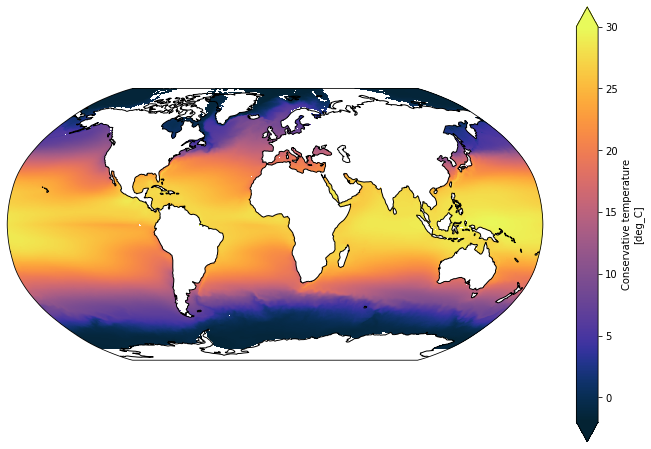

In [7]:
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Robinson())

SST_time_mean.plot(ax=ax,
         x='xt_ocean', y='yt_ocean', 
         transform=ccrs.PlateCarree(),
         vmin=-2, vmax=30, extend='both',
         cmap=cm.cm.thermal)

ax.coastlines();

### Model agnostic

Now do the same calculation in a model agnostic manner

For this data it is necessary to correct the units attribute first. This shouldn't be necessary if the metadata is correct

In [40]:
SST.attrs['units']= 'K'

Now use `pint` to ensure this is in degrees C. Note that if the data was originally in degrees celcius this would be fine, it would do nothing. So this is a way of catering for any temperature units that are understood by pint in a transparent way

In [44]:
SST = SST.pint.quantify().pint.to('C')

In [45]:
SST

<xarray.DataArray 'surface_temp' (time: 288, yt_ocean: 1080, xt_ocean: 1440)>
<Quantity(dask.array<truediv, shape=(288, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>, 'degree_Celsius')>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 1958-01-14T12:00:00 ... 1981-12-14T12:00:00
Attributes:
    long_name:      Conservative temperature
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

Now take the time mean, but this time use the `cf` accessor to automatically determine the name of the time dimension. `cf-xarray` checks the names of variables and coordinates, and associated metadata to try and infer information about the data based on the CF conventions.

To see what `cf-xarray` information is available just evaluate the accessor:

In [46]:
SST.cf

Coordinates:
- CF Axes: * X: ['xt_ocean']
           * Y: ['yt_ocean']
           * T: ['time']
             Z: n/a

- CF Coordinates: * longitude: ['xt_ocean']
                  * latitude: ['yt_ocean']
                  * time: ['time']
                    vertical: n/a

- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

In this case it has found `X`, `Y` and `T` axes, and `longitude`, `latitude` and `time` axes. These are now accessible like a `dict` using the `cf` accessor. Note that it returns the actual coordinate, and the function just wants a simple string argument, which is the name of the coordinate. So the `.name` attribute is what is required:

In [47]:
SST_time_mean = SST.mean(SST.cf['time'].name)
SST_time_mean

<xarray.DataArray 'surface_temp' (yt_ocean: 1080, xt_ocean: 1440)>
<Quantity(dask.array<mean_agg-aggregate, shape=(1080, 1440), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>, 'degree_Celsius')>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
Attributes:
    long_name:      Conservative temperature
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

In the same way the `cf` accessor can be used in the plot

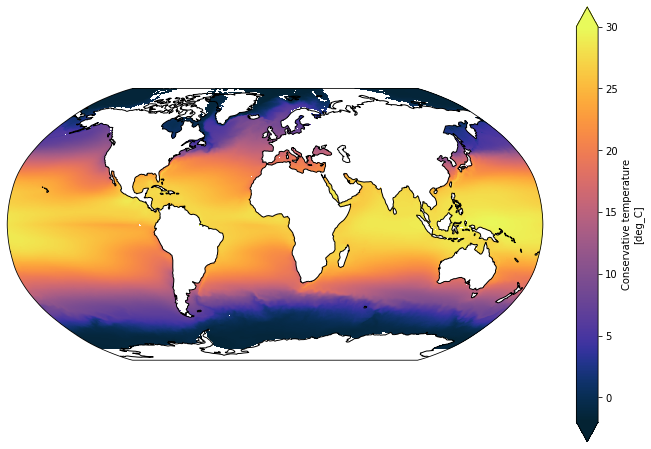

In [9]:
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Robinson())

SST_time_mean.plot(ax=ax,
         x=SST_time_mean.cf['longitude'].name, y=SST_time_mean.cf['latitude'].name, 
         transform=ccrs.PlateCarree(),
         vmin=-2, vmax=30, extend='both',
         cmap=cm.cm.thermal)

ax.coastlines();

## Putting this into practice

Above a model agnostic version of some code was demonstrated, but that doesn't utilise the full power of what it is capable of. The model agnostic code can now be easily turned into a function that accepts an xarray DataArray:

In [56]:
def plot_global_temp_in_degrees_celcius(da):
    # Take the time mean of da and plot a global temperature field in a Robinson projection
    # 
    # Input DataArray (da) should be a 3D array of latitude, longitude and time.
    
    da = da.pint.quantify().pint.to('C')
    da_time_mean = da.mean(da.cf['time'].name)
    
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.Robinson())

    da_time_mean.plot(ax=ax,
         x=da_time_mean.cf['longitude'].name, y=da_time_mean.cf['latitude'].name, 
         transform=ccrs.PlateCarree(),
         vmin=-2, vmax=30, extend='both',
         cmap=cm.cm.thermal)

    ax.coastlines();

Try it out with the SST data used above

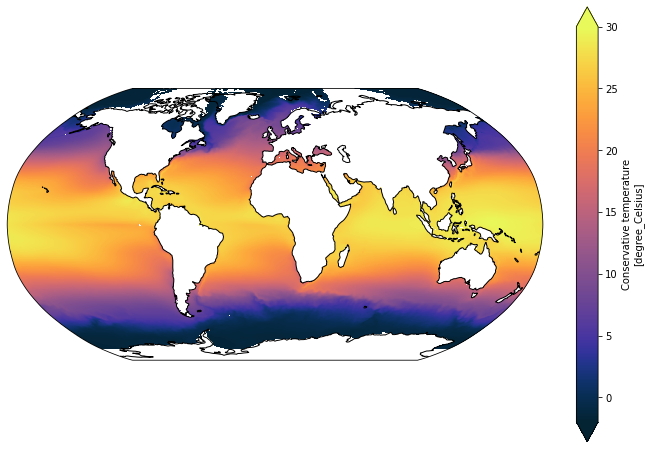

In [57]:
plot_global_temp_in_degrees_celcius(SST)

Ok, so now try on the output from a different model (MOM6):

In [58]:
experiment = 'OM4_025.JRA_RYF'
variable = 'tos'
SST_mom6 = cc.querying.getvar(experiment, variable, session, frequency='1 monthly', n=12)

In [59]:
SST_mom6

<xarray.DataArray 'tos' (time: 144, yh: 1080, xh: 1440)>
dask.array<concatenate, shape=(144, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * time     (time) object 1900-01-16 12:00:00 ... 1911-12-16 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature
    ncfiles:        ['/g/data/ik11/outputs/mom6-om4-025/OM4_025.JRA_RYF/outpu...
    contact:        Andy Hogg
    email:          Andy.Hogg@anu.edu.au
    created:        2021-11-01
    description:    0.25 degree OM4 (MOM6+SIS2) global model configuration un...

In [12]:
SST_mom6.cf

Coordinates:
- CF Axes: * X: ['xh']
           * Y: ['yh']
           * T: ['time']
             Z: n/a

- CF Coordinates: * longitude: ['xh']
                  * latitude: ['yh']
                  * time: ['time']
                    vertical: n/a

- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

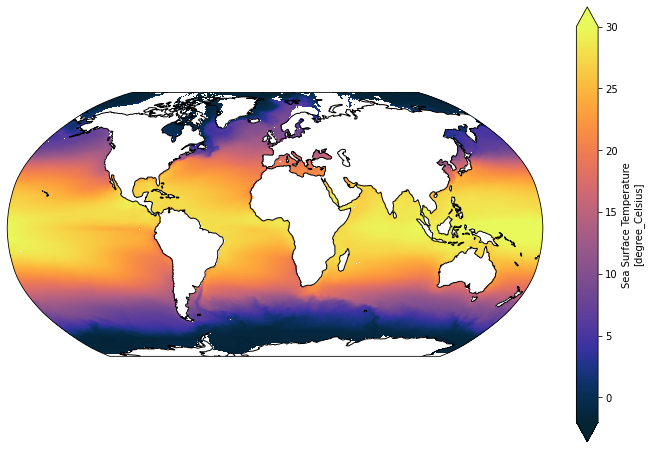

In [60]:
plot_global_temp_in_degrees_celcius(SST_mom6)